<center><h1> Credit Card Fraud Detection </h1></center>
<center> HyperParameter Tuning with HyperOpt, AutoML with h2o</center>

The data can be found here : https://www.kaggle.com/mlg-ulb/creditcardfraud

In this notebook, we'll explore ways to optimize and tune hyper-parameters using :
- Cross validation + Grid Search 
- Cross validation + Randomized Search
- HyperOpt
- h2o Auto-ML

**Context** :
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

**Features** : It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, the original features are not provided. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

# I. Import

In [1]:
### General
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

### Exploration
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from IPython.display import HTML

### Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

### GridSearchCV
from sklearn.model_selection import GridSearchCV

### RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

### HyperOpt Parameter Tuning
from hyperopt import tpe
from hyperopt import STATUS_OK
from hyperopt import Trials
from hyperopt import hp
from hyperopt import fmin

### h2o AutoML
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.automl import H2OAutoML

/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.21.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
df = pd.read_csv('/Users/maelfabien/Desktop/LocalDB/CreditCard/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# II. Data exploration

In [3]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Indeed, only 0.17% of the transactions are fraudulant. We'll use the **F1-Score** metric, a harmonic mean between the precision and the recall.

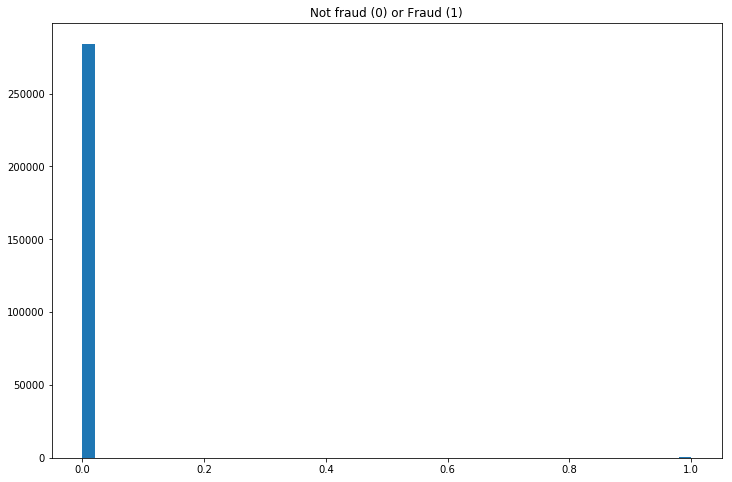

In [4]:
plt.figure(figsize=(12,8))
plt.hist(df['Class'], bins =50)
plt.title("Not fraud (0) or Fraud (1)")
plt.show()

Let's now take a look at the amount of the transactions :

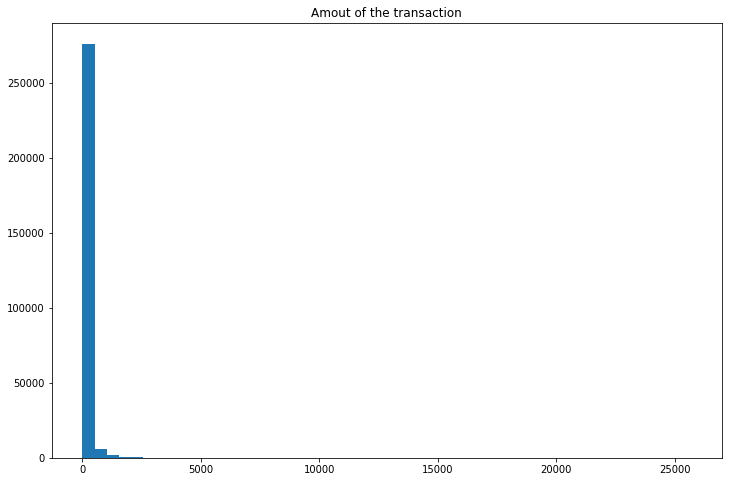

In [5]:
plt.figure(figsize=(12,8))
plt.hist(df.Amount, bins=50)
plt.title("Amout of the transaction")
plt.show()

We notice that most transactions have a very limited amount. Let's now check if fraudulant transactions tend to have a larger or smaller amount :

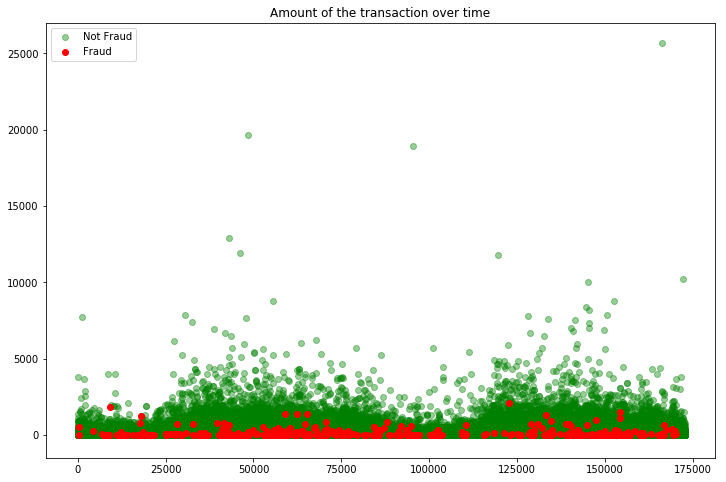

In [6]:
plt.figure(figsize=(12,8))
plt.scatter(df[df.Class == 0].Time, df[df.Class == 0].Amount, c='green', alpha=0.4, label="Not Fraud")
plt.scatter(df[df.Class == 1].Time, df[df.Class == 1].Amount, c='red', label="Fraud")
plt.title("Amount of the transaction over time")
plt.legend()
plt.show()

Fraudulant transactions have a limited amount. We can guess that these transactions must remain "unseen" and not attracting too much attention.

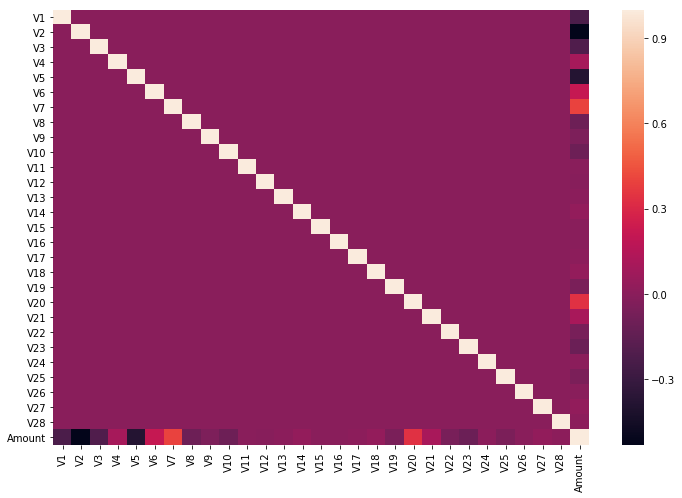

In [18]:
plt.figure(figsize=(12,8))
sns.heatmap(df.iloc[:,1:-1].corr())
plt.show()

We can now group the rows by time unit and observe the evolution of the overall amount of the transactions.

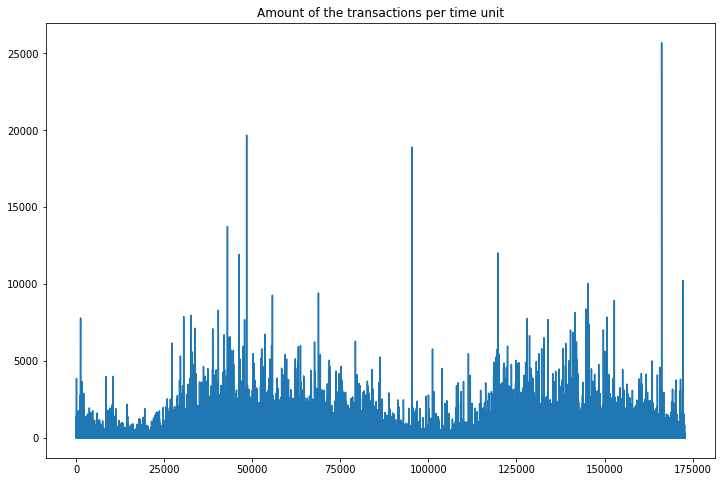

In [19]:
plt.figure(figsize=(12,8))
plt.plot(df.groupby('Time').sum()['Amount'])
plt.title("Amount of the transactions per time unit")
plt.show()

Let's now focus on the fraudulant transactions :

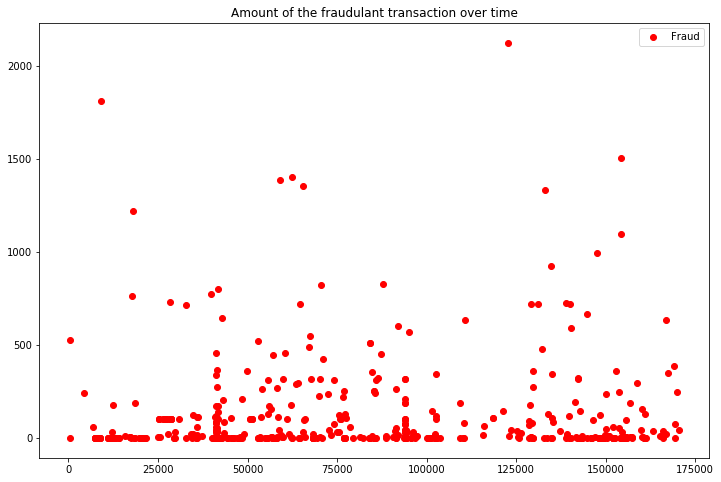

In [20]:
plt.figure(figsize=(12,8))
plt.scatter(df[df.Class == 1].Time, df[df.Class == 1].Amount, c='red', label="Fraud")
plt.title("Amount of the fraudulant transaction over time")
plt.legend()
plt.show()

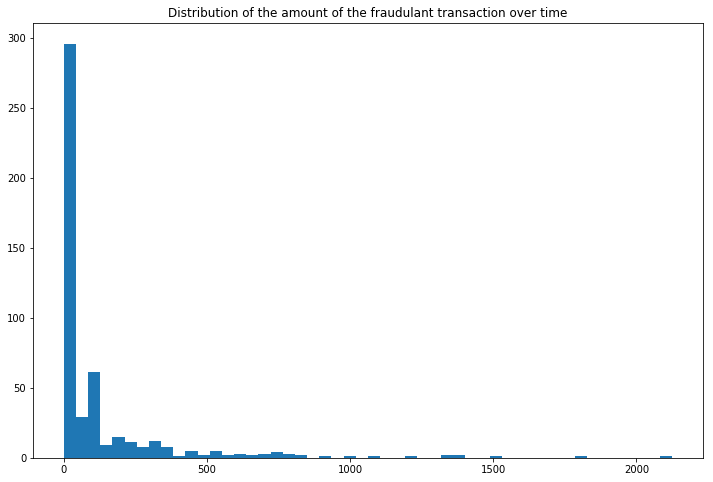

In [21]:
plt.figure(figsize=(12,8))
plt.hist(df[df.Class == 1].Amount, bins=50)
plt.title("Distribution of the amount of the fraudulant transaction over time")
plt.show()

The amount of the average fraudulant transaction does not exceed 125$.

/Users/maelfabien/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


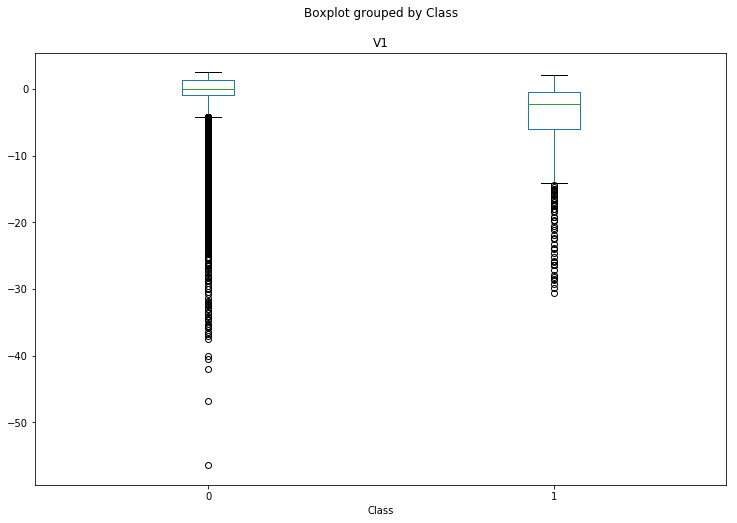

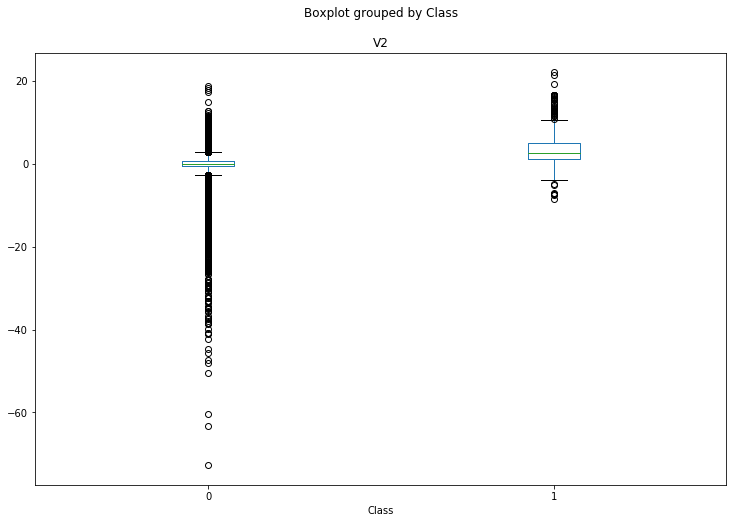

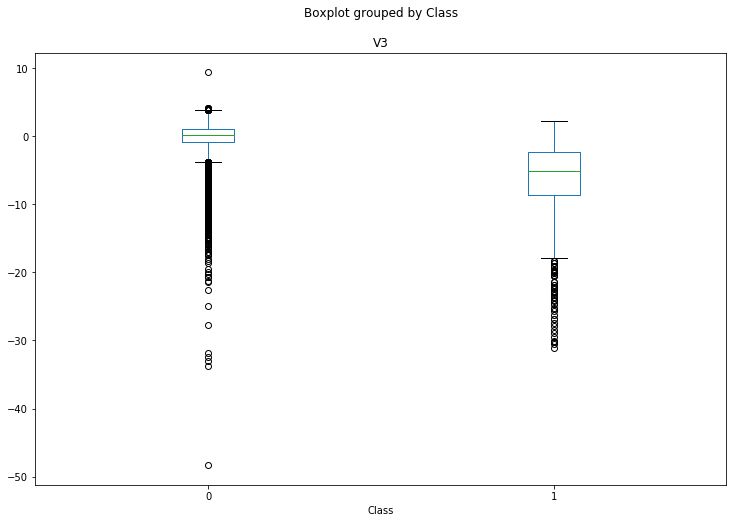

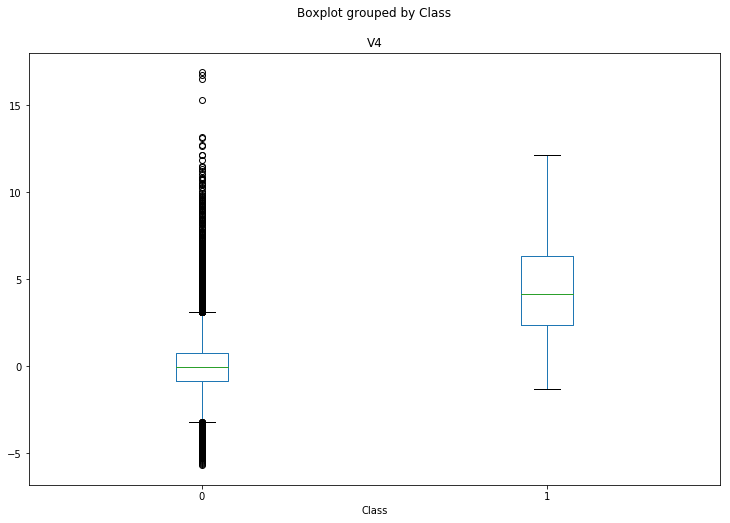

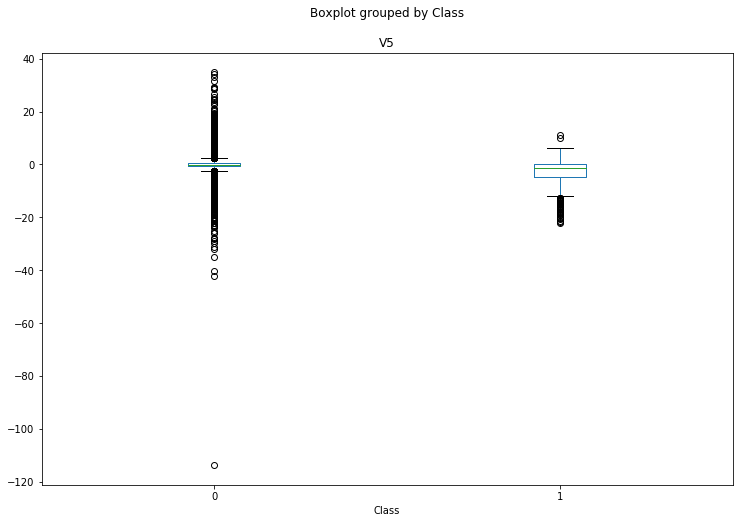

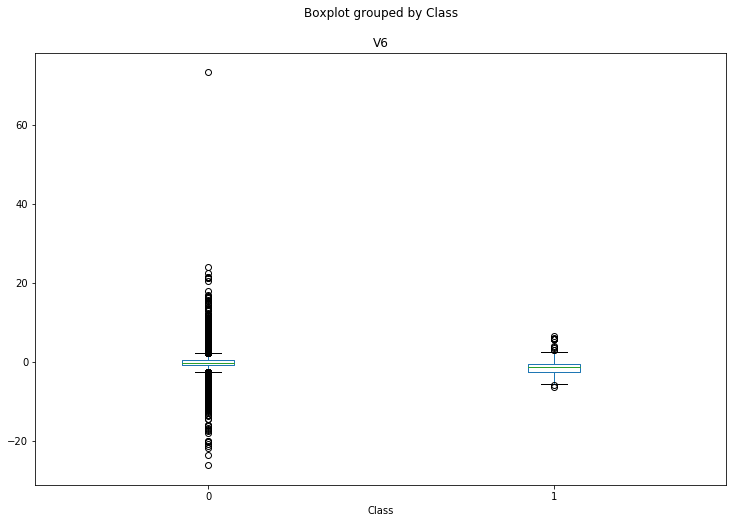

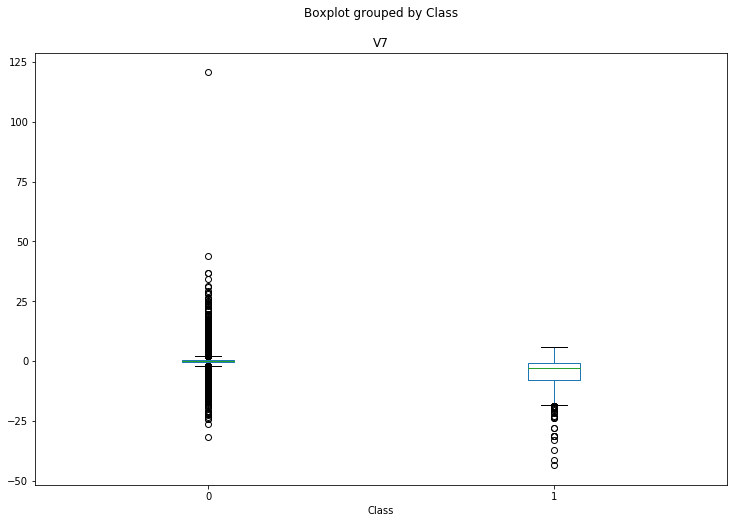

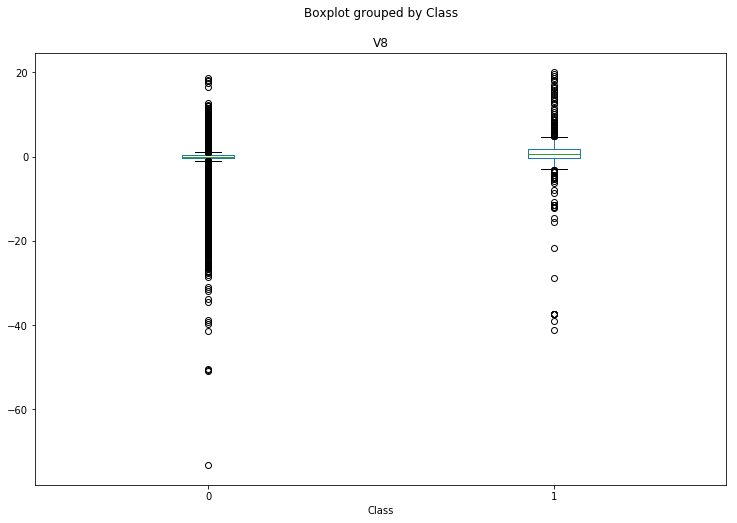

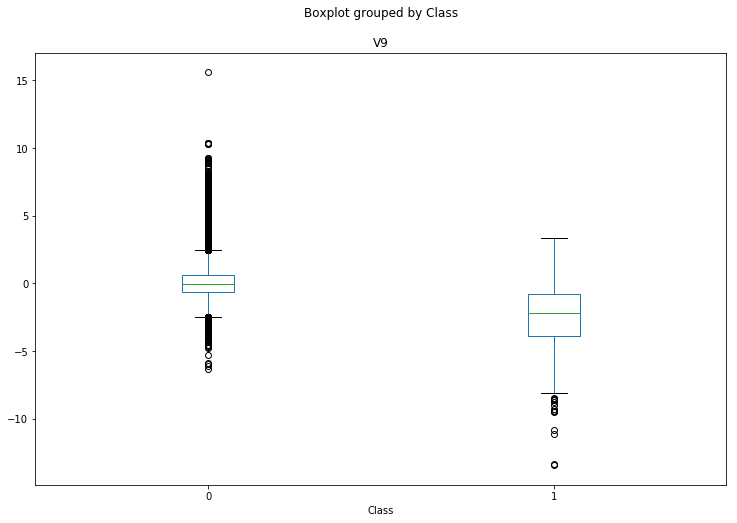

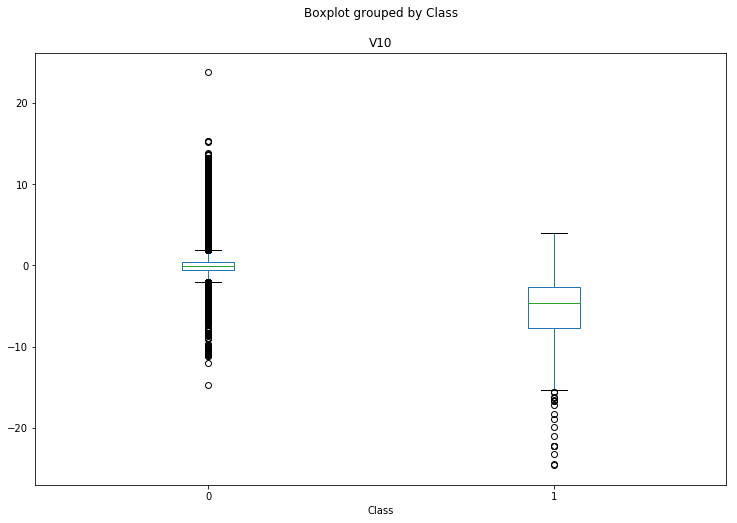

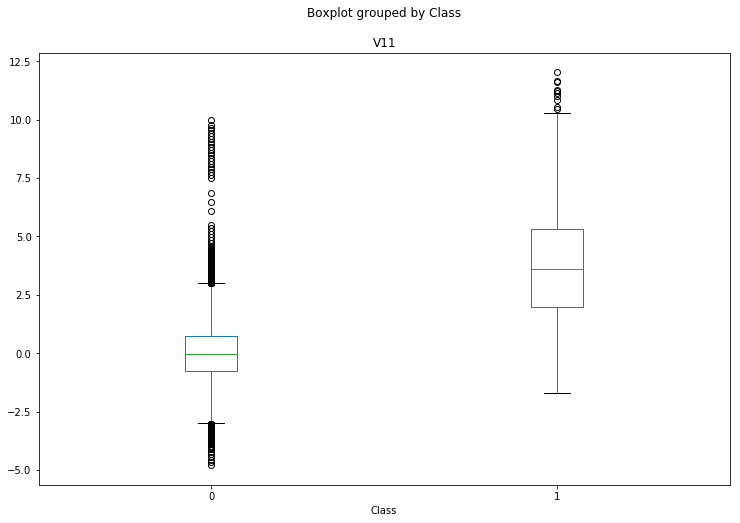

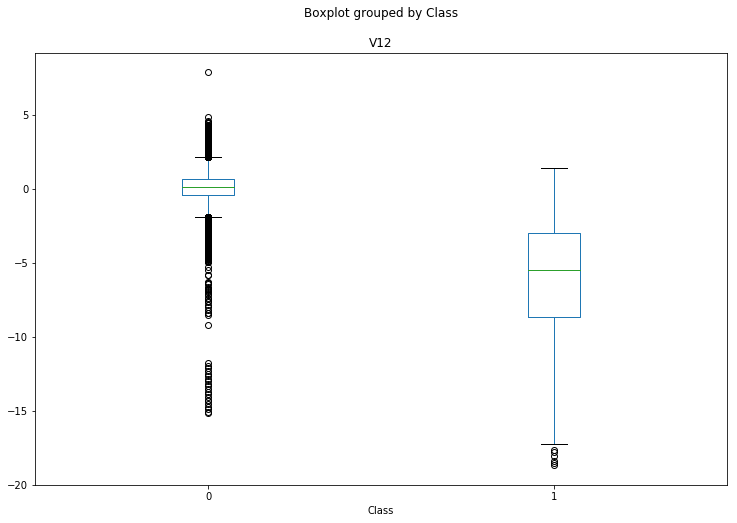

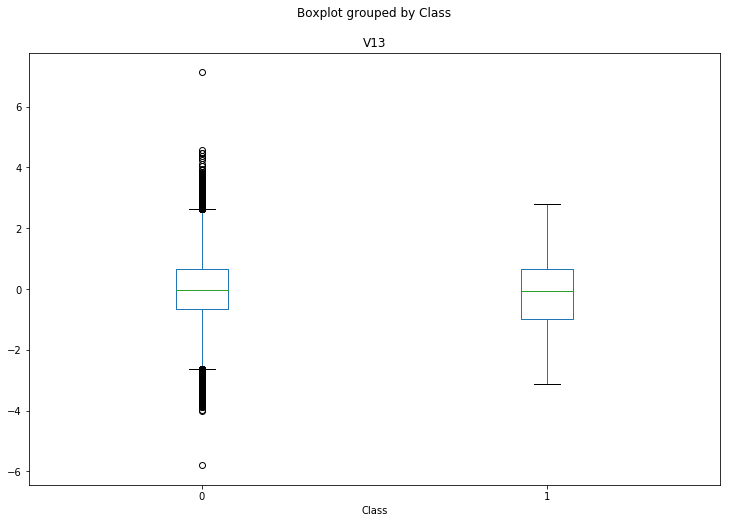

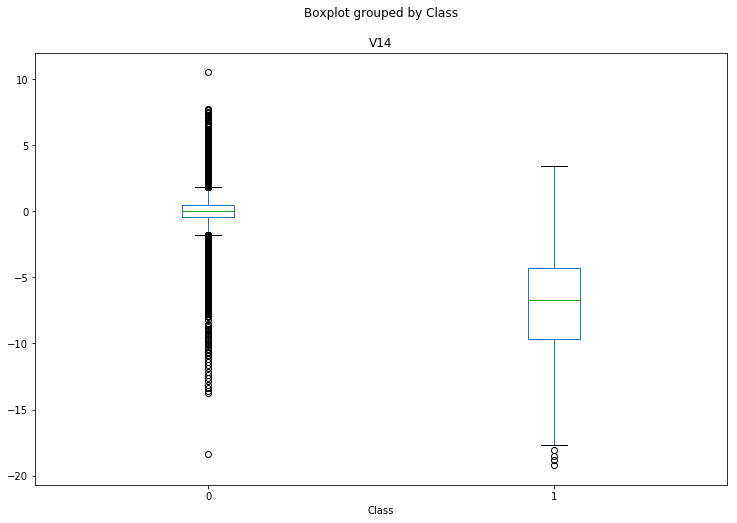

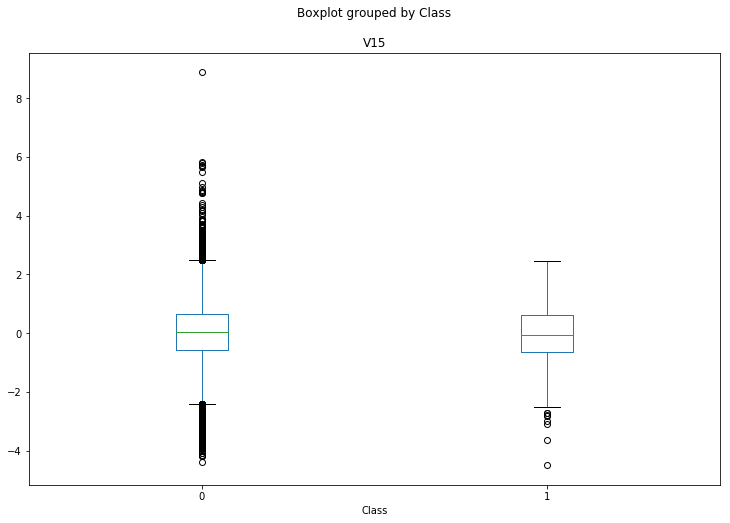

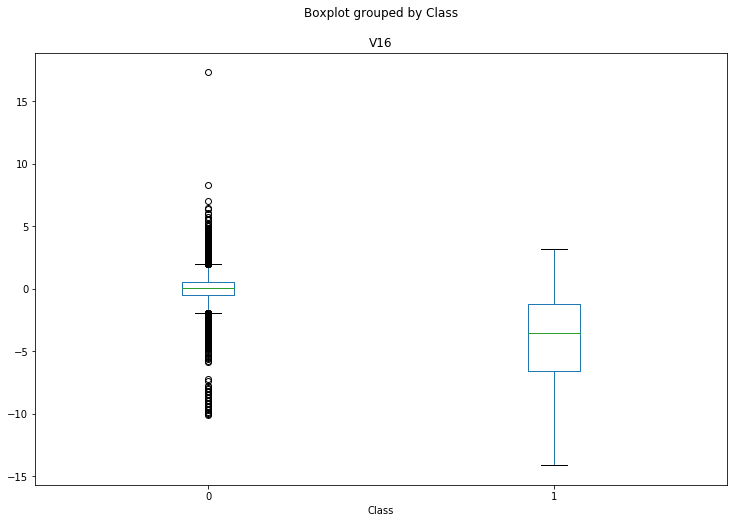

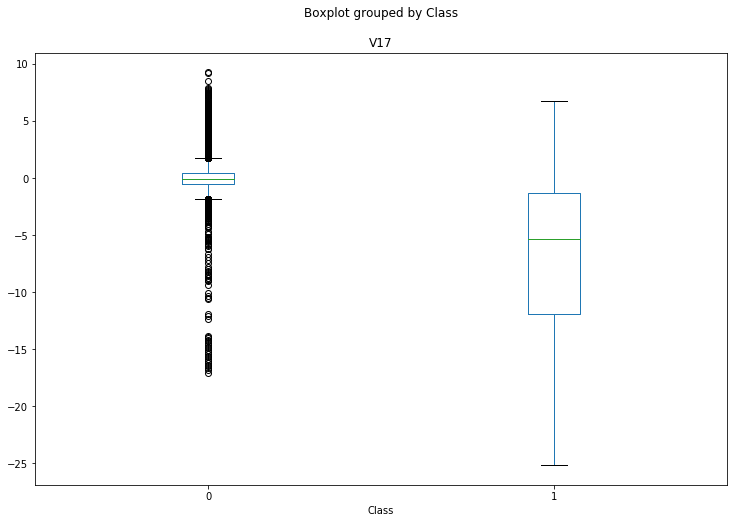

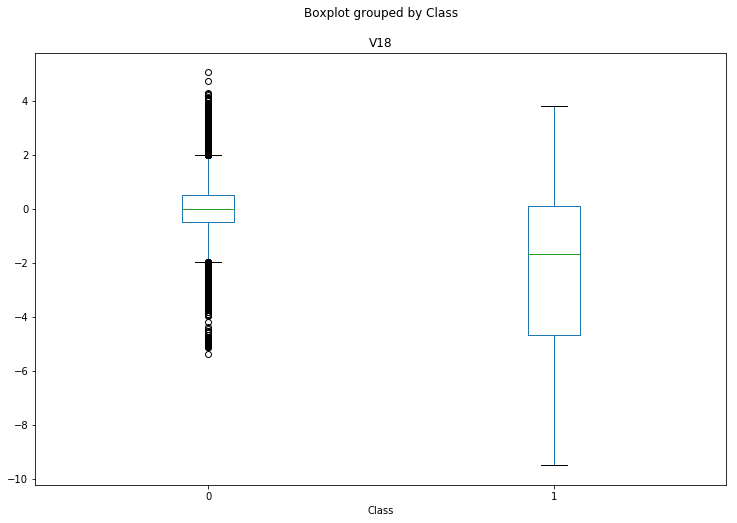

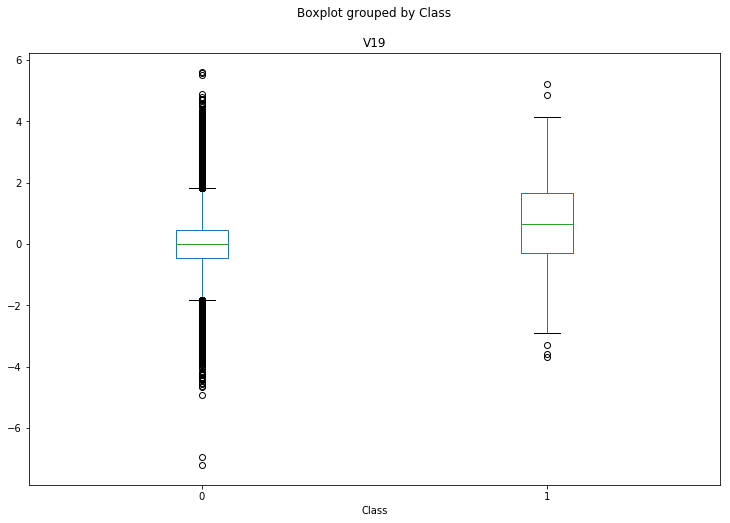

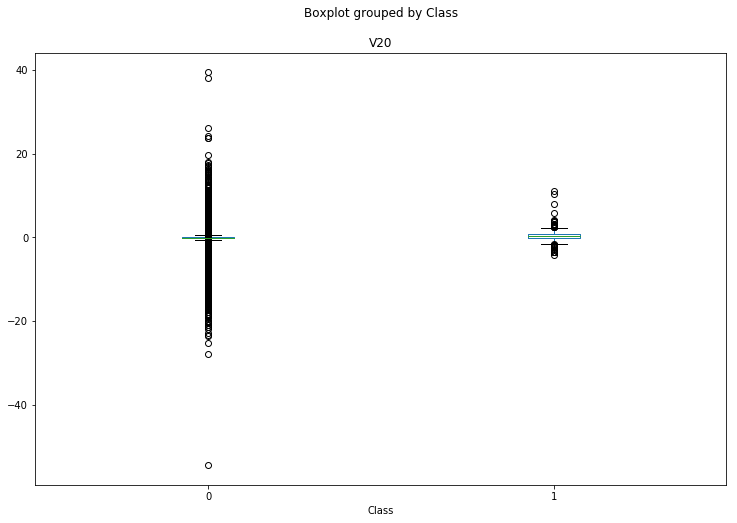

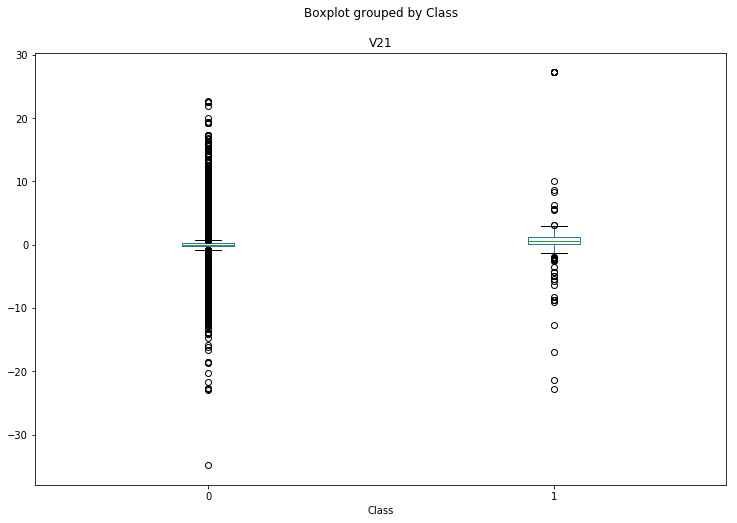

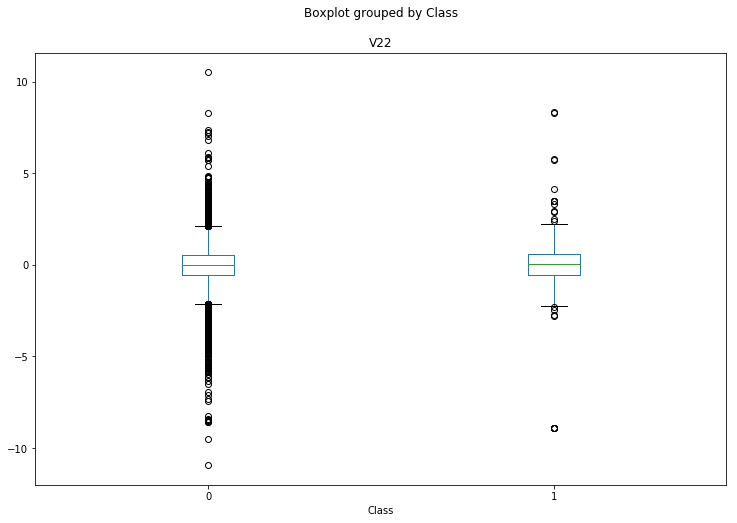

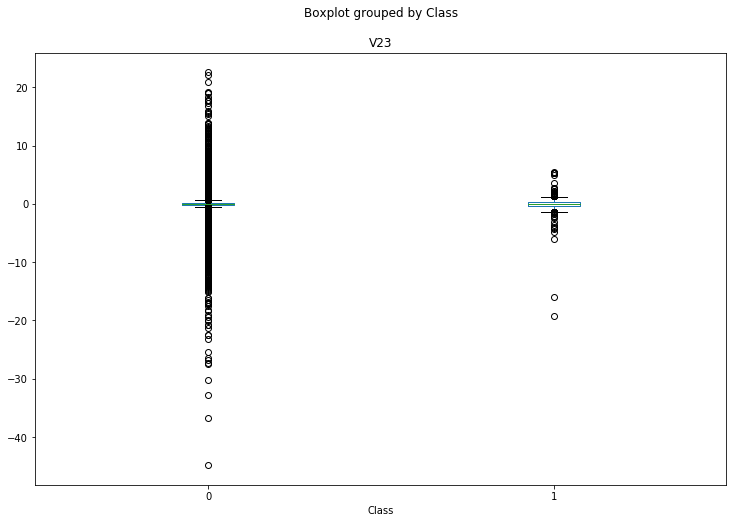

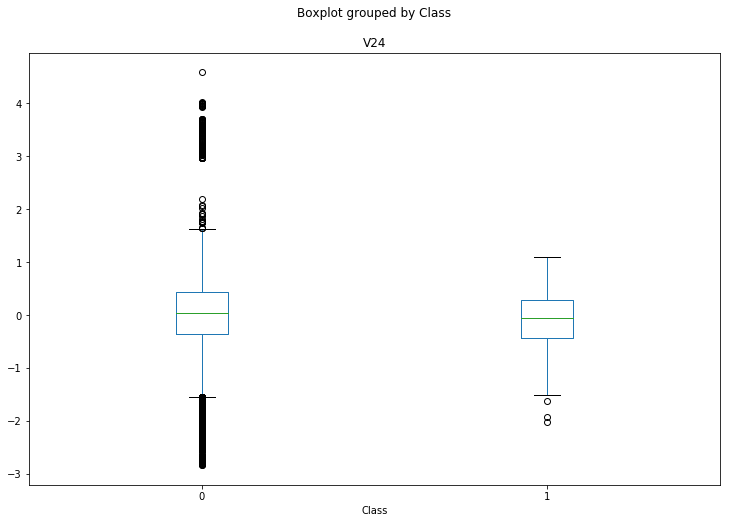

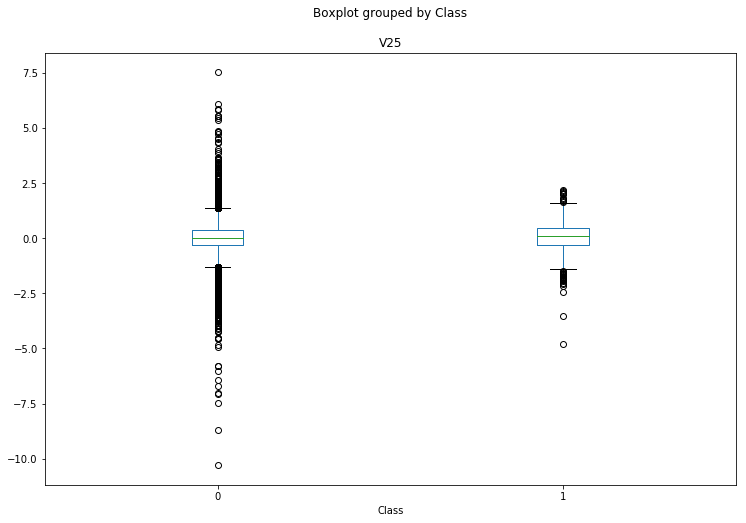

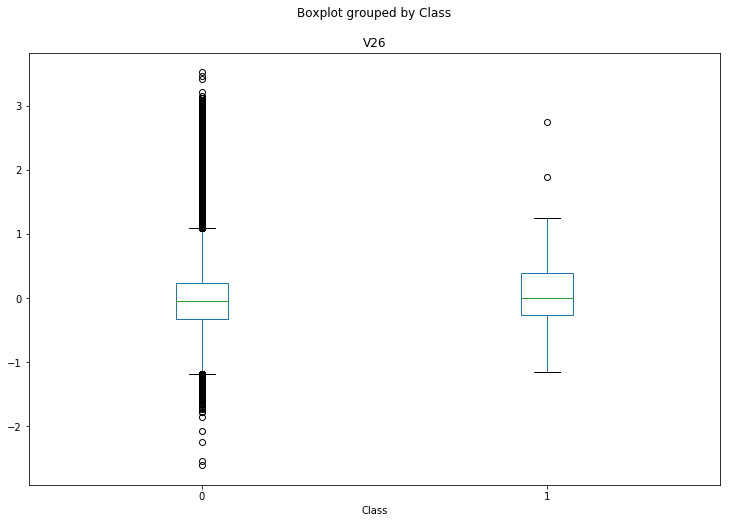

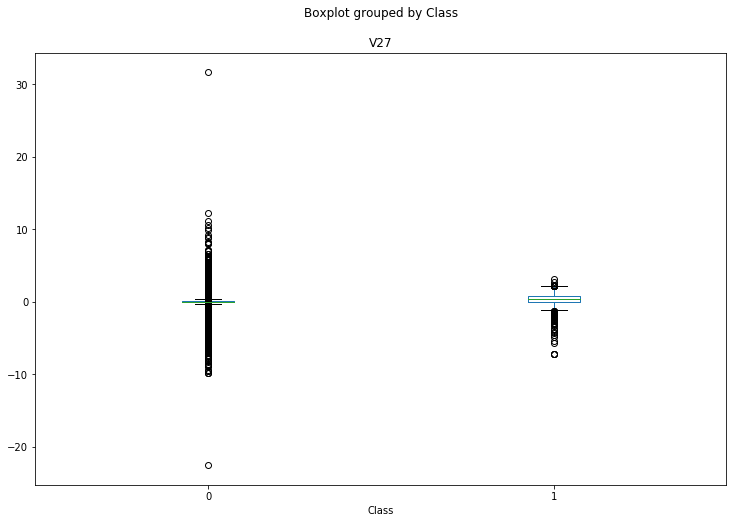

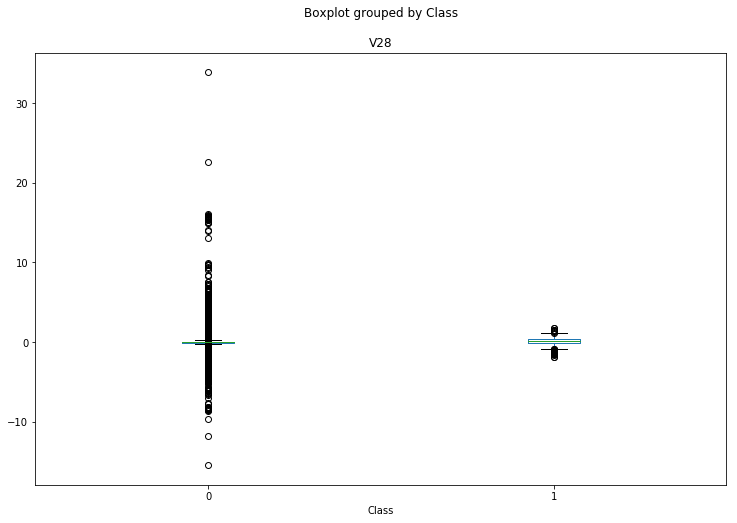

In [22]:
for i in range(1,29) :
    boxplot = df.boxplot(grid=False, column='V'+ str(i), by='Class', figsize=(12,8))
plt.show()

There seems to be some clustering effects for the fraudulant transactions. We are hoping to capture this with our next models, although no clear pattern.

# III. Models

In [97]:
X = df.drop(['Time', 'Class'], axis=1)
y = df['Class']

To evaluate the best model, our first action should always be to perform cross validation.

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

Since the classes are highly imbalanced, we will also be using class weights to equalize the amount of data sent in each batch.

In [5]:
class_weight = {0:df['Class'].sum(), 1:len(df)-df['Class'].sum()}

## 1. Cross Validation + GridSearch

- In Grid Search, we try every combination of a preset list of values of the hyper-parameters.
- We choose the best combination based on the cross validation score.
- We are sure to identify the best parameter combination

In [104]:
tuned_parameters = [{'C': [0.5, 1, 10, 100, 1000]},
                    {'warm_start': [True, False]},
                    {'max_iter' : [50, 150, 250]}]

clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv=5, scoring='f1_macro')

clf.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureW

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [0.5, 1, 10, 100, 1000]}, {'warm_start': [True, False]}, {'max_iter': [50, 150, 250]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [105]:
y_pred = clf.predict(X_test)
print(f1_score(y_pred, y_test))

0.7356321839080459


- Overall execution time is : 4m 41s
- The F1-Score reached is : 73.56 %

## 2. Cross Validation + Randomized Search

- In randomized search, we try random combinations of a range of values. 
- It is good for testing a wide range of values and normally it reaches a very good combination very fast, 
- But the problem that it doesn’t guarantee to give the best parameters combination.

In [114]:
tuned_parameters = {'C': [0.5, 1, 10, 100, 1000],
                    'warm_start': [True, False],
                    'max_iter' : [50, 150, 250]}

clf = RandomizedSearchCV(LogisticRegression(), tuned_parameters, cv=5, scoring='f1_macro', n_iter=2)

clf.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=2, n_jobs=None,
          param_distributions={'C': [0.5, 1, 10, 100, 1000], 'warm_start': [True, False], 'max_iter': [50, 150, 250]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1_macro', verbose=0)

In [116]:
y_pred = clf.predict(X_test)
print(f1_score(y_pred, y_test))

0.7294117647058823


- Overall execution time is : 45.9s
- The F1-Score reached is : 72.94 %
- We got very close to the score of the Grid Search, in a fraction of the time

## 3. HyperOpt

- An efficient way to tune the hyper-parameters is to use HyperOpt, a Bayesian otpimisation implementation.
- Bayesian optimization is effective, but it will not solve all our tuning problems. As the search progresses, the algorithm switches from exploration — trying new hyperparameter values — to exploitation — using hyperparameter values that resulted in the lowest objective function loss. 
- If the algorithm finds a local minimum of the objective function, it might concentrate on hyperparameter values around the local minimum rather than trying different values located far away in the domain space. Random search does not suffer from this issue because it does not concentrate on any values!

In [13]:
N_FOLDS = 10
MAX_EVALS = 50

### 3.a. Logistic Regression

In [14]:
def objective(params, n_folds = N_FOLDS):
    """Objective function for Logistic Regression Hyperparameter Tuning"""
    
    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evalute based on ROC AUC
    
    clf = LogisticRegression(**params,random_state=0,verbose =0)
    scores = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')
  
    # Extract the best score
    best_score = max(scores)
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [15]:
space = {
    'class_weight': hp.choice('class_weight', [None, class_weight]),
    'warm_start' : hp.choice('warm_start', [True, False]),
    'fit_intercept' : hp.choice('fit_intercept', [True, False]),
    'tol' : hp.uniform('tol', 0.00001, 0.0001),
    'C' : hp.uniform('C', 0.05, 3),
    'solver' : hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    'max_iter' : hp.choice('max_iter', range(5,1000))
}

In [18]:
# Algorithm
tpe_algorithm = tpe.suggest
# Trials object to track progress
bayes_trials = Trials()
# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials)

  2%|▏         | 1/50 [00:31<25:57, 31.78s/it, best loss: 0.4574993225009176]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



  4%|▍         | 2/50 [09:54<2:32:56, 191.18s/it, best loss: 0.4034930590550423]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the c

  6%|▌         | 3/50 [19:02<3:53:37, 298.25s/it, best loss: 0.3714731609058355]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the c

  8%|▊         | 4/50 [31:54<5:37:34, 440.31s/it, best loss: 0.3714731609058355]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the c

 10%|█         | 5/50 [47:09<7:17:03, 582.73s/it, best loss: 0.3714731609058355]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')

/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:422: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)

/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/o

 12%|█▏        | 6/50 [47:59<5:10:02, 422.79s/it, best loss: 0.3714731609058355]

/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6

 14%|█▍        | 7/50 [56:21<5:20:01, 446.56s/it, best loss: 0.3714731609058355]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 16%|█▌        | 8/50 [57:03<3:47:38, 325.21s/it, best loss: 0.1488478312035587]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 18%|█▊        | 9/50 [58:26<2:52:31, 252.46s/it, best loss: 0.1488478312035587]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the c

 20%|██        | 10/50 [1:00:17<2:20:10, 210.26s/it, best loss: 0.1488478312035587]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the c

 22%|██▏       | 11/50 [1:50:13<11:19:42, 1045.70s/it, best loss: 0.1488478312035587]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 24%|██▍       | 12/50 [1:50:50<7:50:41, 743.20s/it, best loss: 0.1488478312035587]  

/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')

/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:422: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)

/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')

/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did 

 26%|██▌       | 13/50 [1:51:45<5:31:01, 536.81s/it, best loss: 0.1488478312035587]

/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6

 28%|██▊       | 14/50 [1:57:32<4:47:58, 479.96s/it, best loss: 0.1488478312035587]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the c

 30%|███       | 15/50 [1:59:14<3:33:44, 366.43s/it, best loss: 0.1488478312035587]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the c

 32%|███▏      | 16/50 [2:06:23<3:38:20, 385.32s/it, best loss: 0.1488478312035587]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 34%|███▍      | 17/50 [2:06:57<2:33:49, 279.68s/it, best loss: 0.11063214924610265]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 36%|███▌      | 18/50 [2:18:20<3:33:43, 400.74s/it, best loss: 0.11063214924610265]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 38%|███▊      | 19/50 [2:18:45<2:28:51, 288.12s/it, best loss: 0.11063214924610265]

/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')

/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')

/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search

 40%|████      | 20/50 [2:19:47<1:50:11, 220.40s/it, best loss: 0.11063214924610265]

/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')



 42%|████▏     | 21/50 [2:20:23<1:19:42, 164.90s/it, best loss: 0.11063214924610265]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



 44%|████▍     | 22/50 [2:20:59<58:51, 126.13s/it, best loss: 0.1048094045489395]   

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



 46%|████▌     | 23/50 [2:21:02<40:09, 89.25s/it, best loss: 0.1048094045489395] 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



 48%|████▊     | 24/50 [2:23:04<42:57, 99.14s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



 50%|█████     | 25/50 [2:24:15<37:48, 90.72s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



 52%|█████▏    | 26/50 [2:26:09<39:01, 97.56s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



 54%|█████▍    | 27/50 [2:26:21<27:33, 71.88s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



 56%|█████▌    | 28/50 [2:26:29<19:22, 52.82s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



 58%|█████▊    | 29/50 [2:28:11<23:38, 67.56s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



 60%|██████    | 30/50 [2:30:04<27:03, 81.19s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



 62%|██████▏   | 31/50 [2:31:24<25:36, 80.87s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



 64%|██████▍   | 32/50 [2:32:10<21:08, 70.49s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



 66%|██████▌   | 33/50 [2:32:21<14:55, 52.67s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



 68%|██████▊   | 34/50 [2:32:24<10:04, 37.77s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



 70%|███████   | 35/50 [2:33:21<10:51, 43.44s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



 72%|███████▏  | 36/50 [2:35:02<14:08, 60.59s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



 74%|███████▍  | 37/50 [2:36:08<13:29, 62.30s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



 76%|███████▌  | 38/50 [2:37:13<12:37, 63.16s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did n

 78%|███████▊  | 39/50 [2:44:28<32:02, 174.79s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarni

 80%|████████  | 40/50 [2:44:55<21:43, 130.33s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



 84%|████████▍ | 42/50 [2:46:29<11:52, 89.08s/it, best loss: 0.1048094045489395] 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 86%|████████▌ | 43/50 [2:58:53<33:18, 285.53s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the c

 88%|████████▊ | 44/50 [3:08:01<36:25, 364.33s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



 90%|█████████ | 45/50 [3:08:55<22:35, 271.19s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did n

 92%|█████████▏| 46/50 [3:18:45<24:27, 366.85s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 96%|█████████▌| 48/50 [3:19:58<06:33, 196.88s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 98%|█████████▊| 49/50 [3:24:55<03:46, 226.86s/it, best loss: 0.1048094045489395]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarni

100%|██████████| 50/50 [3:26:00<00:00, 178.28s/it, best loss: 0.1048094045489395]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



In [82]:
best = {'C': 2.959250240545696,
 'class_weight': 0,
 'fit_intercept': 0,
 'max_iter': 245,
 'solver': 1,
 'tol': 2.335533830757049e-05,
 'warm_start': 0}

In [92]:
# Optimal model
clf = LogisticRegression(
 C= 2.959250240545696, 
 fit_intercept= True,
 max_iter= 245,
 solver= 'newton-cg',
 tol= 2.335533830757049e-05,
 warm_start= True)

In [99]:
# Fit-Predict
clf.fit(X_train, y_train)
y_pred =clf.predict(X_test)

In [100]:
f1_score(y_pred, y_test)

0.7356321839080459

### 3.b. Random Forest

In [41]:
def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Tuning"""
    
    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evalute based on ROC AUC
    
    clf = RandomForestClassifier(**params,random_state=0,verbose =0)
    scores = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')
  
    # Extract the best score
    best_score = max(scores)
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [44]:
space = {
    'class_weight': hp.choice('class_weight', [None, class_weight]),
    'warm_start' : hp.choice('warm_start', [True, False]),
    'n_estimators' : hp.choice('n_estimators', range(5,1000)),
    'criterion' : hp.choice('criterion', ['gini', 'entropy']),
    'max_depth' : hp.quniform('max_depth', 10, 150, 2),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']),
    'bootstrap' : hp.choice('bootstrap', [True, False]),
    'oob_score' : hp.choice('oob_score', [True, False]),
}

In [ ]:
tpe_algorithm = tpe.suggest
bayes_trials = Trials()
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials)
best

## 4. h2o Auto-ML

H2O’s AutoML can be used for automating the machine learning workflow, which includes automatic training and tuning of many models within a user-specified time-limit. Stacked Ensembles – one based on all previously trained models, another one on the best model of each family – will be automatically trained on collections of individual models to produce highly predictive ensemble models which, in most cases, will be the top performing models in the AutoML Leaderboard.

In [137]:
# Initialize
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_181"; Java(TM) SE Runtime Environment (build 1.8.0_181-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.181-b13, mixed mode)
  Starting server from /anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/9l/ss26hnmx6qbcmddtxw8jmvy80000gn/T/tmp5plxn66u
  JVM stdout: /var/folders/9l/ss26hnmx6qbcmddtxw8jmvy80000gn/T/tmp5plxn66u/h2o_maelfabien_started_from_python.out
  JVM stderr: /var/folders/9l/ss26hnmx6qbcmddtxw8jmvy80000gn/T/tmp5plxn66u/h2o_maelfabien_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Zurich
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.2
H2O cluster version age:,19 days
H2O cluster name:,H2O_from_python_maelfabien_akxy2s
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [117]:
# Load the data
df = h2o.import_file("/Users/maelfabien/Desktop/LocalDB/CreditCard/creditcard.csv")
d = df.split_frame(ratios = [0.8], seed = 1234)
df_train = d[0] # using 80% for training
df_test = d[1] #rest 20% for testing
df_train.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%


Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.35981,-0.0727812,2.53635,1.37816,-0.338321,0.462388,0.239599,0.0986979,0.363787,0.0907942,-0.5516,-0.617801,-0.99139,-0.311169,1.46818,-0.470401,0.207971,0.0257906,0.403993,0.251412,-0.0183068,0.277838,-0.110474,0.0669281,0.128539,-0.189115,0.133558,-0.0210531,149.62,0
0,1.19186,0.266151,0.16648,0.448154,0.0600176,-0.0823608,-0.078803,0.0851017,-0.255425,-0.166974,1.61273,1.06524,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.0690831,-0.225775,-0.638672,0.101288,-0.339846,0.16717,0.125895,-0.0089831,0.0147242,2.69,0
1,-1.35835,-1.34016,1.77321,0.37978,-0.503198,1.8005,0.791461,0.247676,-1.51465,0.207643,0.624501,0.0660837,0.717293,-0.165946,2.34586,-2.89008,1.10997,-0.121359,-2.26186,0.52498,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.0553528,-0.0597518,378.66,0
2,-1.15823,0.877737,1.54872,0.403034,-0.407193,0.0959215,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.34585,-1.11967,0.175121,-0.451449,-0.237033,-0.0381948,0.803487,0.408542,-0.0094307,0.798278,-0.137458,0.141267,-0.20601,0.502292,0.219422,0.215153,69.99,0
2,-0.425966,0.960523,1.14111,-0.168252,0.420987,-0.0297276,0.476201,0.260314,-0.568671,-0.371407,1.34126,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.0581328,0.0686531,-0.0331938,0.0849677,-0.208254,-0.559825,-0.0263977,-0.371427,-0.232794,0.105915,0.253844,0.0810803,3.67,0
4,1.22966,0.141004,0.0453708,1.20261,0.191881,0.272708,-0.005159,0.0812129,0.46496,-0.0992543,-1.41691,-0.153826,-0.751063,0.167372,0.0501436,-0.443587,0.00282051,-0.611987,-0.045575,-0.219633,-0.167716,-0.27071,-0.154104,-0.780055,0.750137,-0.257237,0.0345074,0.00516777,4.99,0
7,-0.644269,1.41796,1.07438,-0.492199,0.948934,0.428118,1.12063,-3.80786,0.615375,1.24938,-0.619468,0.291474,1.75796,-1.32387,0.686133,-0.076127,-1.22213,-0.358222,0.324505,-0.156742,1.94347,-1.01545,0.0575035,-0.649709,-0.415267,-0.0516343,-1.20692,-1.08534,40.8,0
7,-0.894286,0.286157,-0.113192,-0.271526,2.6696,3.72182,0.370145,0.851084,-0.392048,-0.41043,-0.705117,-0.110452,-0.286254,0.0743554,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.0527357,-0.0734251,-0.268092,-0.204233,1.01159,0.373205,-0.384157,0.0117474,0.142404,93.2,0
10,1.44904,-1.17634,0.91386,-1.37567,-1.97138,-0.629152,-1.42324,0.0484559,-1.72041,1.62666,1.19964,-0.67144,-0.513947,-0.095045,0.23093,0.0319675,0.253415,0.854344,-0.221365,-0.387226,-0.0093019,0.313894,0.0277402,0.500512,0.251367,-0.129478,0.0428499,0.0162533,7.8,0
10,0.384978,0.616109,-0.8743,-0.0940186,2.92458,3.31703,0.470455,0.538247,-0.558895,0.309755,-0.259116,-0.326143,-0.0900467,0.362832,0.928904,-0.129487,-0.809979,0.359985,0.707664,0.125992,0.0499237,0.238422,0.00912987,0.99671,-0.767315,-0.492208,0.0424724,-0.0543374,9.99,0


In [118]:
# Predictor columns
predictors = list(df.columns) 
predictors.remove('Time')
predictors.remove('Class')

In [119]:
# Cast binary
df_train['Class'] = df_train['Class'].asfactor()

In [122]:
aml = H2OAutoML(max_models = 50, seed = 1, max_runtime_secs=21000)

In [123]:
aml.train(x = predictors, y = 'Class', training_frame = df_train, validation_frame = df_test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [124]:
print(aml.leaderboard)

model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_20190506_000950_model_8,0.981646,0.00279929,0.105491,0.0217763,0.000474206
GBM_grid_1_AutoML_20190506_000950_model_13,0.97855,0.00278203,0.106747,0.0212029,0.000449564
GLM_grid_1_AutoML_20190506_000950_model_1,0.977505,0.00403073,0.111985,0.0260326,0.000677699
GBM_grid_1_AutoML_20190506_000950_model_10,0.97727,0.0027134,0.0977369,0.0202304,0.000409271
GBM_grid_1_AutoML_20190506_000950_model_16,0.976829,0.00273863,0.0977566,0.0208157,0.000433294
GBM_grid_1_AutoML_20190506_000950_model_5,0.969094,0.00313117,0.100327,0.0217719,0.000474017
GBM_grid_1_AutoML_20190506_000950_model_17,0.963728,0.00304207,0.101602,0.0220067,0.000484294
DeepLearning_grid_1_AutoML_20190506_000950_model_6,0.95929,0.00727195,0.105513,0.0240526,0.000578527
DeepLearning_grid_1_AutoML_20190506_000950_model_4,0.954595,0.00835674,0.114497,0.0240522,0.00057851
DeepLearning_grid_1_AutoML_20190506_000950_model_3,0.952148,0.0103404,0.106811,0.0246377,0.000607014


In [124]:
print(aml.leader)

model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_20190506_000950_model_8,0.981646,0.00279929,0.105491,0.0217763,0.000474206
GBM_grid_1_AutoML_20190506_000950_model_13,0.97855,0.00278203,0.106747,0.0212029,0.000449564
GLM_grid_1_AutoML_20190506_000950_model_1,0.977505,0.00403073,0.111985,0.0260326,0.000677699
GBM_grid_1_AutoML_20190506_000950_model_10,0.97727,0.0027134,0.0977369,0.0202304,0.000409271
GBM_grid_1_AutoML_20190506_000950_model_16,0.976829,0.00273863,0.0977566,0.0208157,0.000433294
GBM_grid_1_AutoML_20190506_000950_model_5,0.969094,0.00313117,0.100327,0.0217719,0.000474017
GBM_grid_1_AutoML_20190506_000950_model_17,0.963728,0.00304207,0.101602,0.0220067,0.000484294
DeepLearning_grid_1_AutoML_20190506_000950_model_6,0.95929,0.00727195,0.105513,0.0240526,0.000578527
DeepLearning_grid_1_AutoML_20190506_000950_model_4,0.954595,0.00835674,0.114497,0.0240522,0.00057851
DeepLearning_grid_1_AutoML_20190506_000950_model_3,0.952148,0.0103404,0.106811,0.0246377,0.000607014


In [125]:
preds = aml.leader.predict(df_test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [126]:
f1_score(preds['predict'].as_data_frame(), df_test['Class'].as_data_frame())

0.8393782383419689

In [127]:
h2o.shutdown()

[WARNING] in <ipython-input-127-bd1e984f485f> line 1:
    >>> h2o.shutdown()
        ^^^^ Deprecated, use ``h2o.cluster().shutdown()``.
H2O session _sid_8ed7 closed.


In [131]:
aml.coef()

AttributeError: 'H2OAutoML' object has no attribute 'coef'

In [132]:
aml.std_coef_plot()

AttributeError: 'H2OAutoML' object has no attribute 'std_coef_plot'

In [133]:
aml.plot()

AttributeError: 'H2OAutoML' object has no attribute 'plot'

In [134]:
aml.varimp_plot()

AttributeError: 'H2OAutoML' object has no attribute 'varimp_plot'

In [135]:
aml.get_hyperparams(0)

AttributeError: 'H2OAutoML' object has no attribute 'get_hyperparams'

In [136]:
aml.leader()

H2OConnectionError: Connection was closed, and can no longer be used.

In [ ]:
h2o.save_model(aml.leader, path = "./model_credit_card")